# Figures 

## ECCO

In [2]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [3]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
omega_total = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/omega_total_newbins.zarr'))
R1 = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/R1_newbins.zarr'))

In [5]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms_newbins.zarr'))
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (time: 286, sigma2_bin: 99)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-02-13 ... 2015-11-14
    time_snp              (time) datetime64[ns] 1992-03-01 ... 2015-12-01
Data variables: (12/18)
    R1                    (time, sigma2_bin) float64 1.64e+06 ... -5.713e+04
    R2                    (time, sigma2_bin) float64 -2.276e+06 ... -8.799e+04
    R3                    (time, sigma2_bin) float64 -9.906e+03 ... -1.468e+03
    dVdt                  (time, sigma2_bin) float32 -1.173e+07 ... -9.151e+04
    omega_mix             (time, sigma2_bin) float64 -9.24e+06 ... -2.976e+03
    omega_mix_slt         (time, sigma2_bin) float64 -3.099e+06 ... -8.984e+03
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.363e+06 ... 1.814e+04
    omega_trans_rate      (time, sigma2_bin) float64 -1.052e+07 ... 5.508e+04
    omega_trans_rate_slt  (time, sigma2_bin) float64 -2.639e+06 ... 4.907e+04
    omega_trans_rate_th   (time, sigma2_bin) float64 -7.883e+06 ... 6.008e+03
    psi_adv               (time, sigma2_bin) float64 -2.833e+06 ... -8.799e+04
    psi_vel               (time, sigma2_bin) float32 -5.575e+05 ... -0.0

In [6]:
wmt_budget_terms.coords

Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01

In [7]:
omega_total.omega_total[:-1]

<xarray.DataArray 'omega_total' (time: 286, sigma2_bin: 99)>
dask.array<getitem, shape=(286, 99), dtype=float64, chunksize=(286, 99), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [8]:
R1.coords

Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    time_snp    (time) datetime64[ns] dask.array<chunksize=(286,), meta=np.ndarray>

In [9]:
wmt_budget_terms['omega_total'] = omega_total.omega_total[:-1]
wmt_budget_terms['R1'] = R1.R1

In [10]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:               (sigma2_bin: 99, time: 286)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-02-13 ... 2015-11-14
    time_snp              (time) datetime64[ns] 1992-03-01 ... 2015-12-01
Data variables: (12/18)
    R1                    (time, sigma2_bin) float64 dask.array<chunksize=(286, 99), meta=np.ndarray>
    R2                    (time, sigma2_bin) float64 -2.276e+06 ... -8.799e+04
    R3                    (time, sigma2_bin) float64 -9.906e+03 ... -1.468e+03
    dVdt                  (time, sigma2_bin) float32 -1.173e+07 ... -9.151e+04
    omega_mix             (time, sigma2_bin) float64 -9.24e+06 ... -2.976e+03
    omega_mix_slt         (time, sigma2_bin) float64 -3.099e+06 ... -8.984e+03
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.363e+06 ... 1.814e+04
    omega_trans_rate      (time, sigma2_bin) float64 -1.052e+07 ... 5.508e+04
    omega_trans_rate_slt  (time, sigma2_bin) float64 -2.639e+06 ... 4.907e+04
    omega_trans_rate_th   (time, sigma2_bin) float64 -7.883e+06 ... 6.008e+03
    psi_adv               (time, sigma2_bin) float64 -2.833e+06 ... -8.799e+04
    psi_vel               (time, sigma2_bin) float32 -5.575e+05 ... -0.0

## Time mean budgets

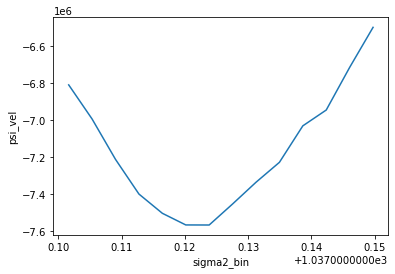

In [11]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.10, 1037.15)).plot()

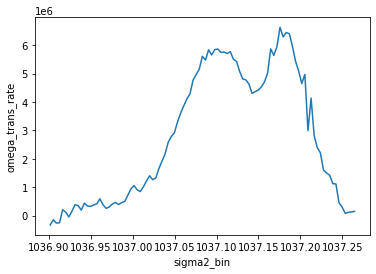

In [12]:
wmt_budget_terms.omega_trans_rate.mean('time').plot()

### $\frac{\partial V}{\partial t}$

In [13]:
#bottom
dVdt_bot = (wmt_budget_terms.dVdt.mean('time')[-1] - 
             wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
dVdt_bot.load()

<xarray.DataArray 'dVdt' ()>
array(1.28811375)

In [14]:
#deep
dVdt_deep = (wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.dVdt.mean('time')[0])/1e6
dVdt_deep.load()

<xarray.DataArray 'dVdt' ()>
array(-1.509369)

In [15]:
(wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6

3.104351291421289

In [16]:
dVdt_bot + dVdt_deep + (wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6

<xarray.DataArray 'dVdt' ()>
array(2.88309604)

### E-P-R

In [17]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

ds_ll = faces_dataset_to_latlon(ds)

ds_before_drop = ds_ll.roll(i=50, i_g=50)

ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

#WG boundaries (65˚W, 30˚E; 80˚S, 55˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745# 93 #-55.107994˚
j_g_lower = 31
j_g_upper = 81
i_g_right = 119
i_g_left = 24

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(j_g_lower, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(i_g_left, i_g_right))

#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

/tmp/ipykernel_723/2556715282.py:5: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_before_drop = ds_ll.roll(i=50, i_g=50)


In [18]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [19]:
ds_wg.oceFWflx

<xarray.DataArray 'oceFWflx' (time: 288, j: 50, i: 95)>
dask.array<getitem, shape=(288, 50, 95), dtype=float32, chunksize=(1, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    Depth    (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
Dimensions without coordinates: j, i
Attributes:
    long_name:      net surface Fresh-Water flux into the ocean (+=down), >0 ...
    standard_name:  oceFWflx
    units:          kg/m^2/s

In [20]:
ds_wg.rA

<xarray.DataArray 'rA' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 67), chunktype=numpy.ndarray>
Coordinates:
    Depth    (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
Dimensions without coordinates: j, i
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [21]:
mask = ds_wg.hFacC[0]>0

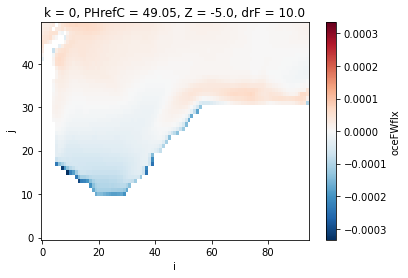

In [22]:
ds_wg.oceFWflx.mean(dim='time').where(mask).plot()

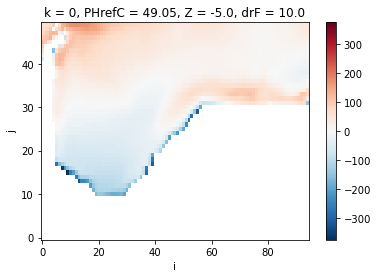

In [23]:
((ds_wg.oceFWflx*ds_wg.rA)/1035).mean('time').where(mask).plot()

In [24]:
e_minus_p = (ds_wg.oceFWflx * ds_wg.rA) / 1035 #m^3/s
e_minus_p.load()

<xarray.DataArray (time: 288, j: 50, i: 95)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ 86.99016   , 101.049     , 103.93102   , ...,   0.94915915,
           0.9775815 ,   1.2242587 ],
        [ 80.44932   ,  95.00412   ,  96.52832   , ...,   3.9090254 ,
           2.9930742 ,   3.0234442 ],
        [ 68.97897   ,  76.67485   ,  78.98671   , ...,   7.749116  ,
           6.74586   ,   5.9742537 ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [258.9434    , 289.2397    , 346.86627   , ..., 215.19272   ,
         223.83514   , 238.52647   ],
        [191.3968    , 252.30124   , 269.50195   , ..., 231.49101   ,
         246.5602    , 268.0985    ],
        [159.6993    , 172.75107   , 245.60216   , ..., 230.56105   ,
         247.29898   , 265.55716   ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ 40.627224  ,  50.929268  ,  77.06169   , ...,  47.285713  ,
          54.297752  ,  59.146935  ],
        [ 40.449493  ,  49.373077  ,  48.212868  , ...,  41.702724  ,
          41.63829   ,  31.432756  ],
        [ 34.475506  ,  38.87792   ,  44.579494  , ...,  39.75984   ,
          36.158787  ,  26.107569  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    Depth    (j, i) float32 0.0 0.0 0.0 0.0 ... 5.184e+03 5.196e+03 5.197e+03
    XC       (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    YC       (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    iter     (time) int64 732 1428 2172 2892 ... 208164 208908 209628 210360
    rA       (j, i) float32 6.898e+08 6.944e+08 ... 2.635e+09 2.635e+09
Dimensions without coordinates: j, i

In [25]:
sigma2_vars = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/sigma2_vars.zarr'))
sigma2 = sigma2_vars.sigma2

delta_sigma = 3.7e-3
sigma_bins = np.arange(1036.9, 1037.27, delta_sigma)

/tmp/ipykernel_723/3729408013.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  sigma2_vars = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/sigma2_vars.zarr'))


In [26]:
fw = (- histogram(sigma2.isel(k=0).rename('sigma2'), bins=[sigma_bins],
                 weights=e_minus_p.fillna(0.),
                 dim=['i', 'j']) / (- delta_sigma)).load()
fw

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 99)>
array([[      0.   ,       0.   ,       0.   , ...,       0.   ,
              0.   ,       0.   ],
       [      0.   ,       0.   ,       0.   , ...,       0.   ,
              0.   ,       0.   ],
       [-106035.16 ,       0.   , -255601.44 , ...,       0.   ,
              0.   ,       0.   ],
       ...,
       [  88071.19 ,  -22024.652,   26014.018, ...,       0.   ,
              0.   ,       0.   ],
       [ 549499.9  ,  974321.   ,  630340.2  , ...,       0.   ,
              0.   ,       0.   ],
       [ 203622.75 ,  173358.2  ,  327163.16 , ...,       0.   ,
              0.   ,       0.   ]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

### $\Psi$

In [27]:
psi_bot = (wmt_budget_terms.psi_vel.mean('time')[-1] - 
           wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
psi_bot.load()

<xarray.DataArray 'psi_vel' ()>
array(7.565823)

In [28]:
fw_bot = (fw.mean('time')[-1] - fw.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
fw_bot.load()

<xarray.DataArray 'histogram_sigma2' ()>
array(0.03239342)

In [29]:
psi_deep = (wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
            wmt_budget_terms.psi_vel.mean('time')[0])/1e6
psi_deep.load()

<xarray.DataArray 'psi_vel' ()>
array(-8.353571)

In [30]:
fw_deep = (fw.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
            fw.mean('time')[0])/1e6
fw_deep.load()

<xarray.DataArray 'histogram_sigma2' ()>
array(0.07955087)

In [31]:
(wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray 'R2' ()>
array(0.26585707)

In [32]:
#residual from transport in (deep wm) and out (bottom wm) after considering E-P-2 and R2 term
psi_bot + psi_deep + fw_bot + fw_deep + (wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray ()>
array(-0.40994665)

### $\Omega$

In [33]:
#bottom
omega_bot = (wmt_budget_terms.omega_trans_rate.mean('time')[-1] - 
             wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
omega_bot.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(-5.34814462)

In [34]:
#deep
omega_deep = (wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6
omega_deep.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(5.82737966)

In [35]:
omega_bot + omega_deep

<xarray.DataArray 'omega_trans_rate' ()>
array(0.47923504)

In [36]:
(wmt_budget_terms.omega_trans_rate.mean('time')[-1] - wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(0.47923504)

### Budget

In [72]:
dVdt_bot

<xarray.DataArray 'dVdt' ()>
array(1.28811375)

In [76]:
psi_bot + omega_bot + fw_bot

<xarray.DataArray ()>
array(2.18528496)

(-8.0, 8.0)

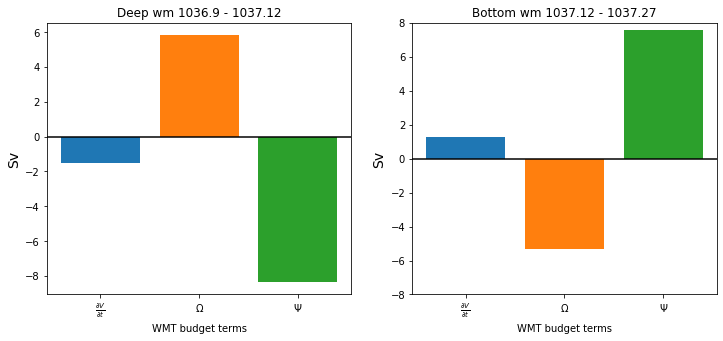

In [66]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_deep)
ax0.bar(x=r'$\Omega$', height = omega_deep)
ax0.bar(x=r'$\Psi$', height=psi_deep)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_bot)
ax1.bar(x=r'$\Omega$', height = omega_bot)
ax1.bar(x=r'$\Psi$', height=psi_bot)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')

plt.ylim(-8,8);

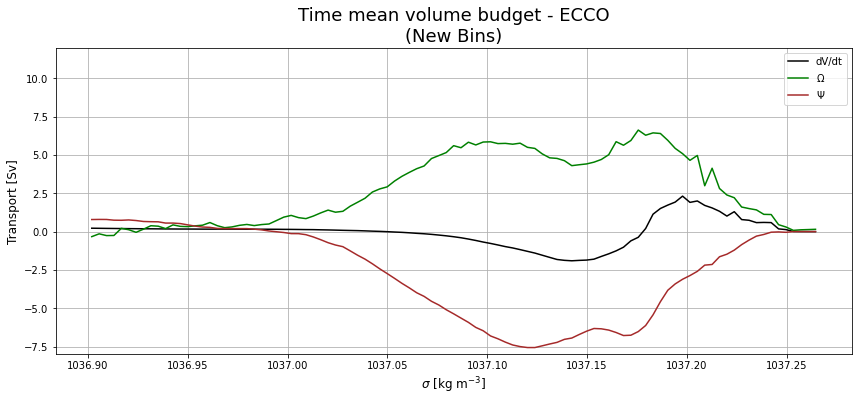

In [45]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
#(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title('Time mean volume budget - ECCO\n(New Bins)', fontsize=18);

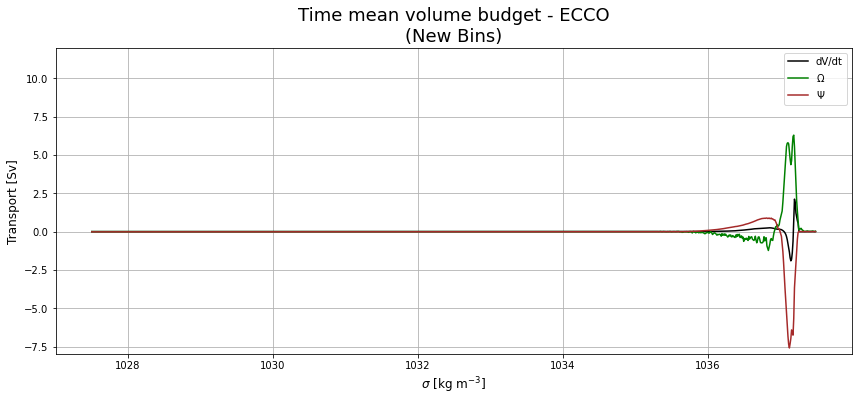

In [48]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
#(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title('Time mean volume budget - ECCO\n(New Bins)', fontsize=18);

In [21]:
def d_dsigma(da):
    """d/dsigma function to switch to formation view"""
    da = (da.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin')) / 1e6
    return da

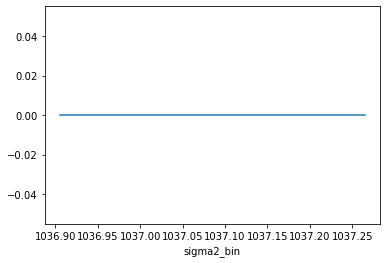

In [22]:
#check function works
(((wmt_budget_terms.omega_trans_rate.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin'))/1e6) - 
 d_dsigma(wmt_budget_terms.omega_trans_rate)).mean('time').plot();
#it works

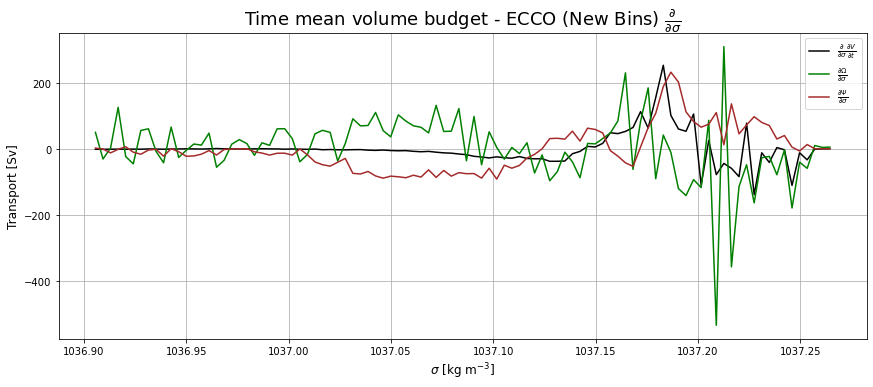

In [43]:
d_dsigma(wmt_budget_terms.dVdt).mean(dim='time').plot(label=r'$\frac{\partial}{\partial \sigma} \frac{\partial V}{\partial t}}$',
                                                      color='k', figsize=(12,5))
d_dsigma(wmt_budget_terms.omega_trans_rate).mean(dim='time').plot(label=r'$\frac{\partial \Omega}{\partial \sigma}$', color='green')
#d_dsigma(wmt_budget_terms.omega_trans_rate_th).mean(dim='time').plot(label=r'$\frac{\partial \Omega_{\theta}}{\partial \sigma}$', 
#                                                                     color='steelblue', linestyle='dashed')
#d_dsigma(wmt_budget_terms.omega_trans_rate_slt).mean(dim='time').plot(label=r'$\frac{\partial \Omega_S}{\partial \sigma}$', 
#                                                                      color='goldenrod', linestyle='dashed')
d_dsigma(wmt_budget_terms.psi_vel).mean(dim='time').plot(label=r'$\frac{\partial \Psi}{\partial \sigma}$', color='brown')
#d_dsigma(wmt_budget_terms.R2).mean(dim='time').plot(label=r'$\frac{\partial R2}{\partial \sigma}$', color='salmon')
#d_dsigma(wmt_budget_terms.R1).mean(dim='time').plot(label=r'$\frac{\partial R1}{\partial \sigma}$', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - ECCO (New Bins) $\frac{\partial}{\partial \sigma}$', fontsize=18);